In [72]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
from IPython import display
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider

batch_num = 0

In [127]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

In [128]:
vae = VAE()
vae.set_weights('./vae/weights.h5')

In [129]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_files = np.load('./data/rnn_files.npz') 
rnn_input = rnn_files['rnn_input']
rnn_output = rnn_files['rnn_output']

log_var = np.load('./data/initial_z.npz')['initial_log_var']

In [130]:
log_var.shape

(4364, 32)

array([ 1,  2,  3,  6,  8,  9, 15, 16, 19, 20, 27, 29, 30])

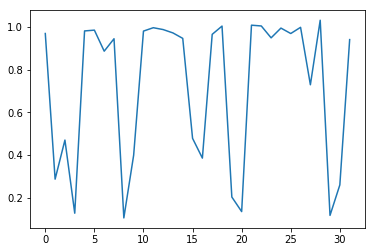

In [131]:
plt.plot(np.exp(log_var[0]/2))
hot_zs = np.where(np.exp(log_var[0]/2) < 0.9)[0]
hot_zs

In [132]:
rnn_input.shape

(100, 299, 36)

In [133]:
rnn_output.shape

(100, 299, 33)

In [134]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [135]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
    N = pdf.size
    accumulate = 0
    for i in range(0, N):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

In [136]:
def sample_z(mu, log_sigma):
    z =  mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) * 0
    return z

In [137]:
np_random, seed = seeding.np_random()

In [138]:
rnn.forward.output_shape

[(None, None, 481), (None, 256), (None, 256)]

In [139]:
def sample_next_mdn_output(obs, h, c):
    
    d = GAUSSIAN_MIXTURES * Z_DIM

    out = rnn.forward.predict([np.array([[obs]]),np.array([h]),np.array([c])])
    
    y_pred = out[0][0][0]
    new_h = out[1][0]
    new_c = out[2][0]
    
    z_pred = y_pred[:3*d]
    rew_pred = y_pred[-1]

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)
    
    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)
    
    # adjust temperatures
    logmix2 = np.copy(log_pi)
    logmix2 -= logmix2.max()
    logmix2 = np.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(z_dim, 1)

    for j in range(z_dim):
        idx = get_pi_idx(np_random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j,idx]
        chosen_log_sigma[j] = log_sigma[j,idx]
        
    next_z = sample_z(chosen_mu, chosen_log_sigma)

    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0

    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi, rew_pred, next_reward, new_h, new_c

In [140]:
run_idx = 10

# real = obs_data[run_idx]
obs = rnn_input[run_idx]
actual = rnn_output[run_idx] 

idx = 1

10.962937853857314
[[0.18329863]]
[10.169941  9.631152 10.081795  8.653618  9.905812]


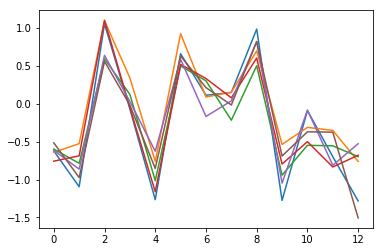

In [141]:
d = GAUSSIAN_MIXTURES * Z_DIM

print(sum(np.abs(obs[idx,hot_zs])))

plt.plot(actual[idx,hot_zs])


y_pred = rnn.model.predict(np.array([[obs[idx,:]]]))

z_pred = y_pred[:,:,:(3*d)]
rew_pred = y_pred[:,:,-1]

print(rew_pred)

z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

log_pi, mu, log_sigma = np.split(z_pred, 3, 1)


plt.plot(mu[hot_zs])

log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

print(sum(np.abs(mu)))


In [142]:
current_z = obs[idx]
i = idx
current_h = np.zeros(256)
current_c = np.zeros(256)

KeyboardInterrupt: 

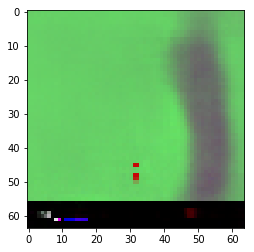

In [144]:

next_z = obs[idx,:]
next_h = np.zeros(256)
next_c = np.zeros(256)
# next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
# plt.imshow( next_z_decoded)
# plt.show()

for i in range(200):
#     print(np.array([[next_z]]).shape)
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)

    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
#     next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]


    next_z = np.concatenate([next_z, [1,1,0], [next_reward]])
    
    print(rew_pred)

#     plt.subplot(211)
    plt.gca().cla() 
    plt.imshow( next_z_decoded)
#     plt.show()
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
#     time.sleep(0.02) 

#     plt.subplot(221)
#     plt.imshow( next_mu_decoded)
#     plt.show()bbc
    # plt.imshow(next_z_decoded)
    # plt.show()

In [ ]:
hot_zs

In [ ]:

def play_with_z(z3 = next_z[3],z5= next_z[5],z6= next_z[6],z10= next_z[10],z16= next_z[16],z17= next_z[17],z20= next_z[20],z22= next_z[22],z25= next_z[25],z31= next_z[31]):
    z = next_z.copy()
    z[3] = z3
    z[5] = z5
    z[6] = z6
    z[10] = z10
    z[16] = z16
    z[17] = z17
    z[20] = z20
    z[22] = z22
    z[25] = z25
    z[31] = z31
    z = z[:32]
    next_z_decoded = vae.decoder.predict(np.array([z]))[0]
    plt.gca().cla() 
    plt.imshow( next_z_decoded)
#     plt.show()
#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 



interact(play_with_z
         , z3=(-3.0,3.0,0.1)
        , z5=(-3.0,3.0,0.1)
        , z6=(-3.0,3.0,0.1)
        , z10=(-3.0,3.0,0.1)
        , z16=(-3.0,3.0,0.1)
        , z17=(-3.0,3.0,0.1)
        , z20=(-3.0,3.0,0.1)
         , z22=(-3.0,3.0,0.1)
        , z25=(-3.0,3.0,0.1)
         , z31=(-3.0,3.0,0.1)
   
        )

In [100]:

next_z, chosen_mu, chosen_log_sigma, chosen_pi, next_reward = sample_next_mdn_output(next_z)

next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]

next_z = np.concatenate([next_z, [0,1,0]])

plt.imshow( next_z_decoded)

TypeError: sample_next_mdn_output() missing 2 required positional arguments: 'h' and 'c'

(33, 299)


/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


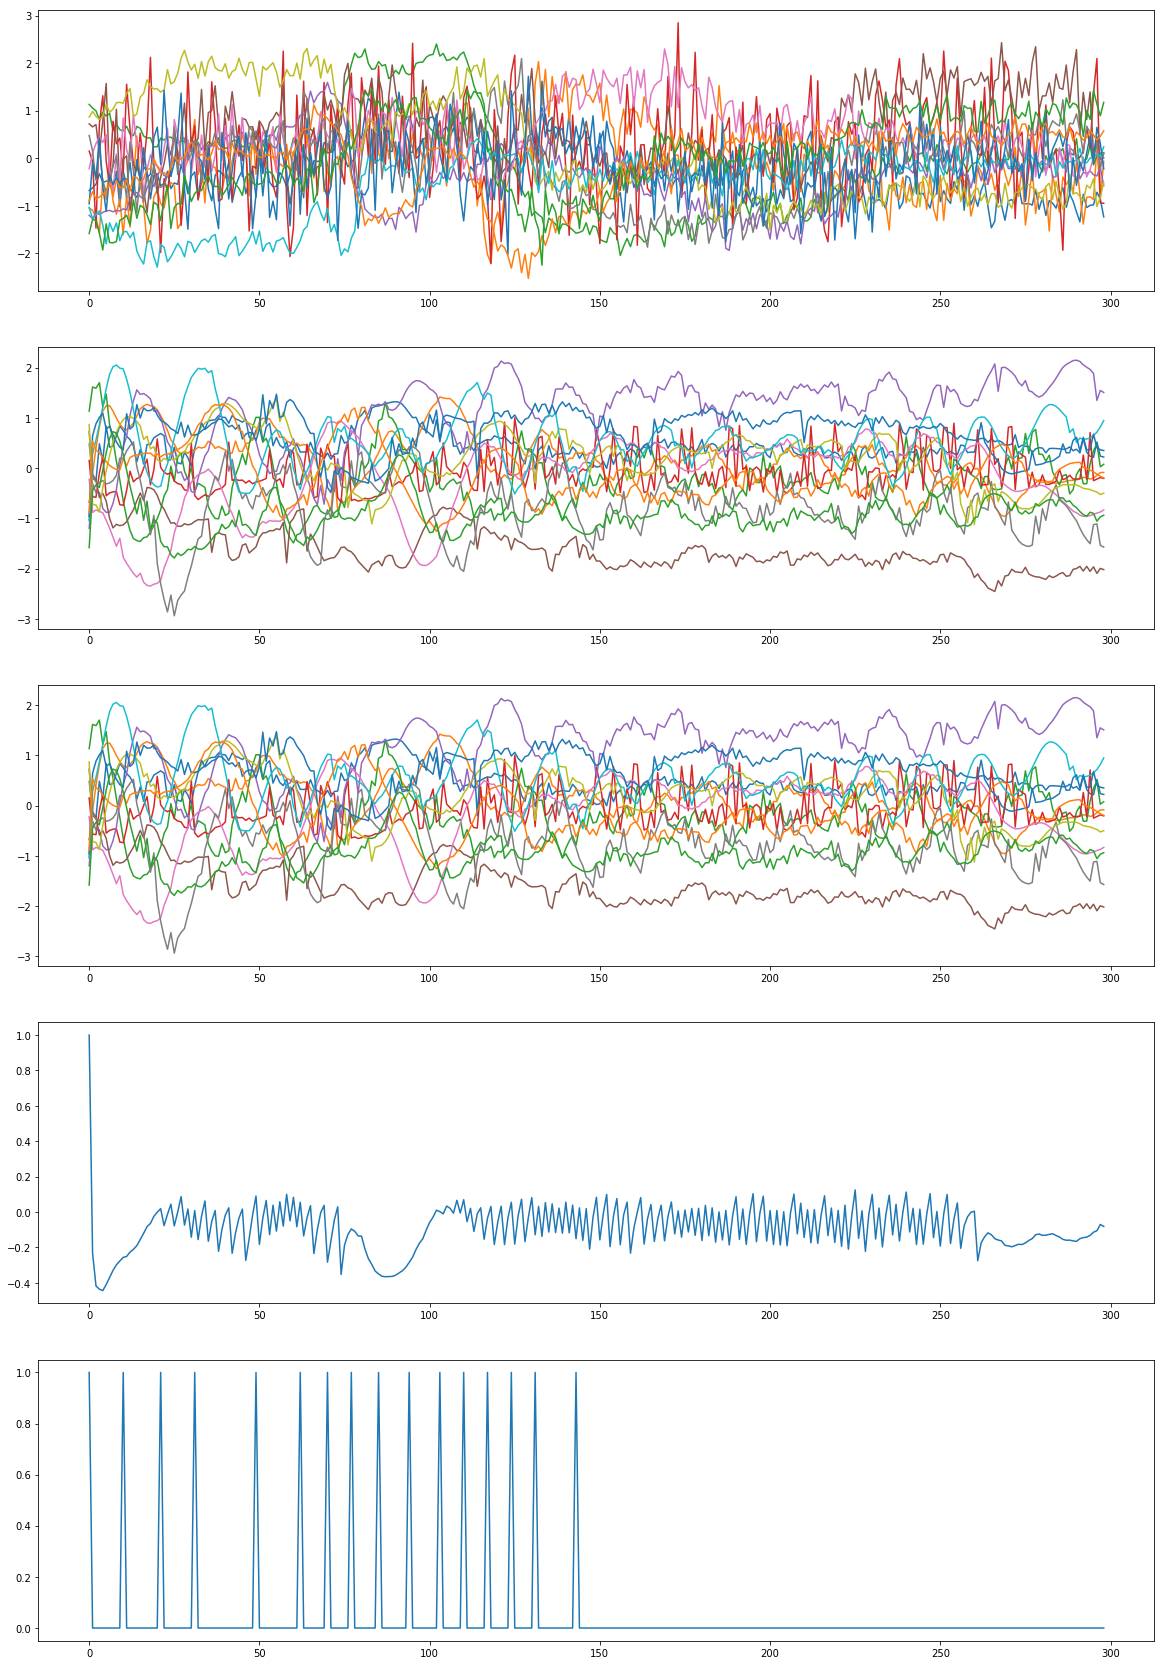

In [145]:
b = np.swapaxes(actual,0,1)
print(b.shape)
actual_rew = b[-1,:]

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
next_rews = np.zeros(shape = (1,299))
# next_z = np.copy(obs)
# print(next_z.shape)
next_z = obs[idx,:]

next_mus[:,0] = next_z[:32]
next_zs[:,0] = next_z[:32]
next_rews[:,0] = next_z[-1]

for i in range(1,299):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi, rew_pred, next_reward, next_h, next_c = sample_next_mdn_output(next_z, next_h, next_c)
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_rews[:,i] = rew_pred
    
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
#     plt.gca().cla() 
#     plt.imshow( next_z_decoded)
# #     plt.show()
#     display.clear_output(wait=True)
#     display.display(plt.gcf()) 
    
    next_z = np.concatenate([next_z, [1,1,0], [next_reward]])

plt.figure(figsize=(20,30))
for i in hot_zs:
    plt.subplot(511)
    plt.plot( b[i,:])
    plt.subplot(512)
    plt.plot( next_zs[i,:])
    plt.subplot(513)
    plt.plot( next_mus[i,:])
    
plt.subplot(514)
plt.plot(next_rews[0,:])

plt.subplot(515)
plt.plot(actual_rew[:])
    
# print(next_zs)
    